In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 52 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='W',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 7

# Start the timer
start_time = time.time()

# Generate the forecast
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) 

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken to generate the forecast: {elapsed_time:.4f} seconds")

# Display the first 5 rows of the forecast
Y_hat_df.head(5)

Time taken to generate the forecast: 5417.7521 seconds


,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-01,128.970810,128.575699,128.582779,128.755661
AAPL,2023-01-08,128.411148,128.590485,128.270660,128.842407
AAPL,2023-01-15,128.896225,128.605270,129.309387,128.849304
AAPL,2023-01-22,128.489151,128.620071,130.797852,129.584747
AAPL,2023-01-29,128.810181,128.634857,131.616898,129.752563


In [6]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae         mse      mape       rmse     smape:
0  16.361635  315.796129  0.110725  17.770654  11.833128

Model: AutoETS
         mae         mse      mape       rmse     smape:
0  16.440146  317.228763  0.111294  17.810917  11.893958

Model: AutoTheta
         mae         mse      mape       rmse    smape:
0  14.987985  259.164844  0.101603  16.098598  10.78158

Model: CES
        mae         mse      mape       rmse     smape:
0  16.00931  299.811931  0.108404  17.315078  11.562102

Results for MSFT:
Model: AutoARIMA
         mae         mse      mape       rmse     smape:
0  28.817455  938.426246  0.114958  30.633744  12.284038

Model: AutoETS
         mae         mse      mape       rmse     smape:
0  24.739192  682.248875  0.098759  26.119894  10.443119

Model: AutoTheta
         mae         mse      mape       rmse     smape:
0  27.924458  861.021007  0.111541  29.343159  11.876774

Model: CES
         mae         mse      mape       rm

In [7]:
cv_df = sf.cross_validation(df=Y_train_df, h=7, n_windows=3, step_size=7, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2022-08-13,2022-08-06,169.836792,175.757629,169.883881,181.631393,170.803635,147.836441,193.770813,170.284714,165.931656,174.726318,170.116852,163.450378,176.926208
AAPL,2022-08-20,2022-08-06,162.014297,181.588303,171.089478,192.087112,171.196838,138.594269,203.799408,169.848679,163.496124,176.680374,170.979462,164.231445,177.885635
AAPL,2022-08-27,2022-08-06,154.280945,186.040359,169.245163,202.835556,171.590057,131.509033,211.671066,163.783173,156.484909,171.199234,171.437317,164.685837,178.621307
AAPL,2022-09-03,2022-08-06,155.825668,191.496323,167.813080,215.179581,171.983261,125.526321,218.440201,163.793228,154.629074,173.451355,171.545792,164.546585,178.377640
AAPL,2022-09-10,2022-08-06,149.221100,196.801865,165.340149,228.263565,172.376480,120.239326,224.513626,160.737183,150.788193,169.390015,171.208099,164.472244,178.262375


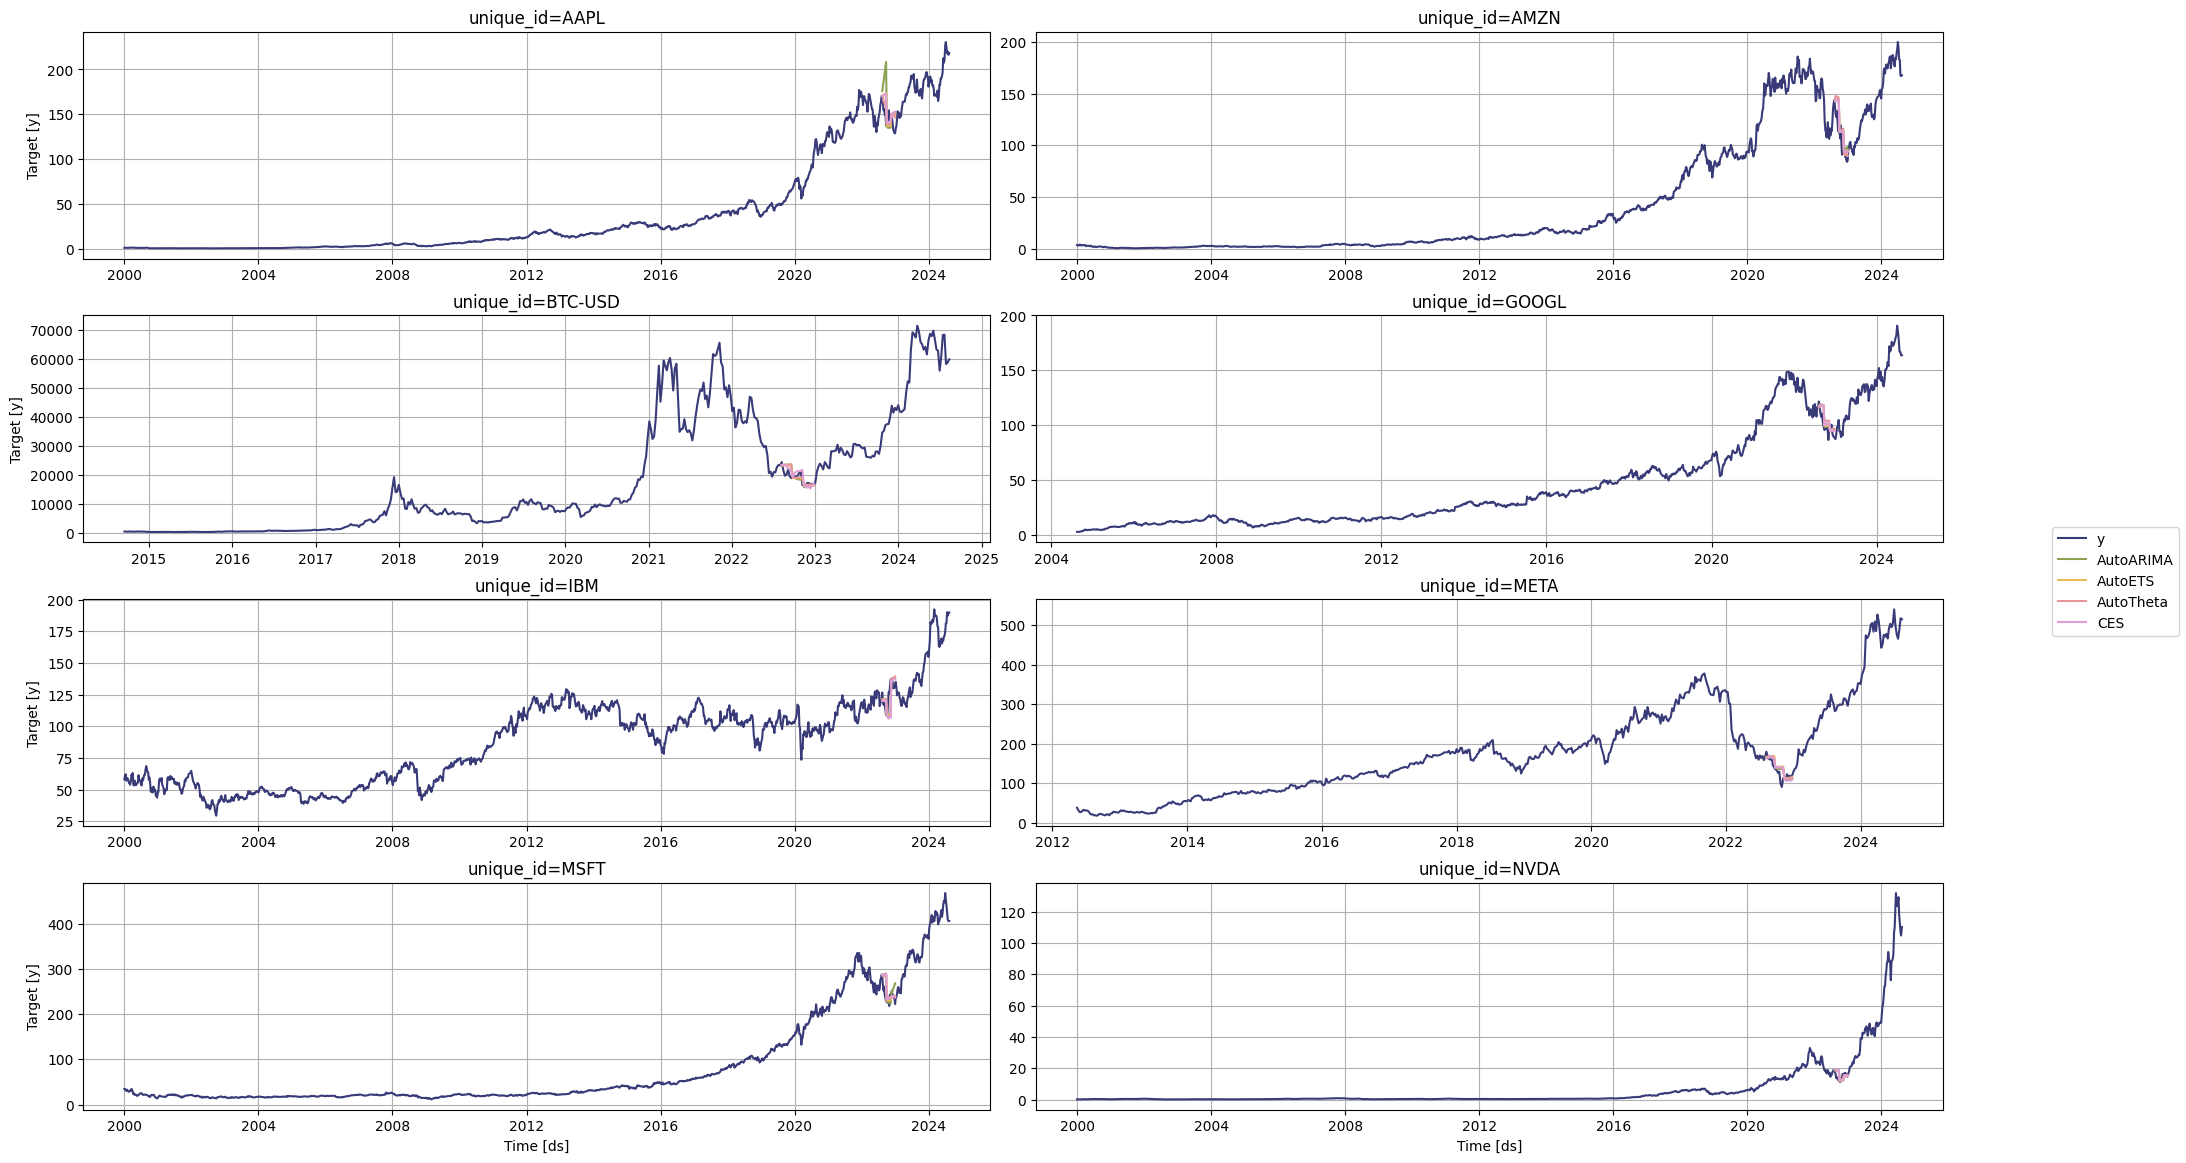

In [8]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))